# Hollywood Actors 
###  Can we predict if an actor won the Oscar based on the career article in Wikipedia?

Shmuel Naaman 

## Methods used for the analysis

###  LSTM, Topic Extraction, Cosine Similarities, TfIdf


### Introduction:
#### Since the performance of the naive model is not satisfactory, here I try another approach that is more elegant. 

The main reason for the low performance of the naive model is the multi topics in the "Holywood Actors" Wikipedia articles. Some of the topics are not relevant to the target variable. Therefore introduces noise and reduce the performance. 

Here I try a different approach to improve the performance. The idea is to extract and identifies the main topics in the articles using unsupervised learning. That will allow us to choose only relevant input for the model.  

I use the same list of actors that appears on 'Hollywood Walk of Fame motion picture stars' to choose articles. This is not a complete list but it includes most of the significant actors in the Hollywood industry. I also improve the articles extraction so most of the actors have articles. The list includes around 900 actors 200 of them were nominated to Oscar and another 350 won or nominated to an Oscar. 


#### The model classifies actors that won or nominated to the Oscar as one category and the other actors as the second category.

#### Overview: 

I focus my efforts on efficient but basic preprocessing that will enhance the signal. 
 * I perform basic cleaning of the data, remove numbers, stop words, tokenize words.
 * Latent Dirichlet allocation (LDA) and Non-Negative Matrix Factorization (NMF) is implemented to identifies 5 different topics in the articles.  
 * TfIdf and Cosine Similarities are used to identifies the 4 sentences in each document that are most relevant to the target variable "Oscar". 
 * Only these 4 sentences will be used as input for the model. 
 * I choose to use an artificial recurrent neural network (RNN) architecture of the type Long short-term memory (LSTM). LSTM networks are well-suited to classifying, processing and making predictions based on time series data.
 
These steps allow me to reduce the dimension of the problem and obtain better results despite the relatively small dataset.  

### importing libraries

In [1]:
import re
import nltk
import string 
import numpy as np
import pandas as pd
import wikipediaapi
import wikipedia as wp
import tensorflow as tf 
from collections import Counter
from nltk import word_tokenize, pos_tag
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer
from sklearn.metrics.pairwise import linear_kernel

## Utils
Optimally these functions would be in a separate file. However, since they include important steps of the analysis I decided to present them here with the rest of the analysis. 


### Clean the data

 * Remove the words 'section', 'subsections' and 'Career' since they are related to the article and not the actor. 
 * The years in the articles were found to have a strong signal for the unsupervised learning, therefore, were removed.  
 * Use word_tokenize to reduce the dimension of the problem and strength the signal.  
 * That will simplify the dataset by reducing the dimension of the data. 
 
 

In [2]:

def preprocess(text):
    # Replace punctuation with tokens so we can use them in our model 
    # We remove the word 'Oscar' from the article
    # We did remove the words 'section' and 'Career' since they are related with the articale and not the actor
    # There are many other preprocessing that worth considering here for example the work 'nomination' 
    # We want to keep it simple and at the same time to demonstrate the analysis
    # section subsections career
 

    text = text.lower()
    text = text.replace('section', ' ')
    text = text.replace('0', ' ')
    text = text.replace('1', ' ')
    text = text.replace('2', ' ')
    text = text.replace('3', ' ')
    text = text.replace('4', ' ')
    text = text.replace('5', ' ')
    text = text.replace('6', ' ')
    text = text.replace('7', ' ')
    text = text.replace('8', ' ')
    text = text.replace('9', ' ')
    text = text.replace('subsections', ' ')
    text = text.replace('career', ' ')
 
   

    return  text
 

In [3]:

# Import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

# Create Lemmatizer object
lemma = WordNetLemmatizer()

# Stem words
def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    # Break the paragraph into sentences
    tokenized_sent = sent_tokenize(document)
     
    for sentence in tokenized_sent:
 
        # Seperating sentences to words
        tokenized_word = word_tokenize(sentence)
         
        # Identify nouns, verbs, adjectives, and adverbs.
        tagged_token = pos_tag(tokenized_word)
        
        # Clasify to root word Text Normalization "performing" -> "perform"
        lemmatized = lemmatize_word(tagged_token)
        
        #lemmatized=LancasterStemmer(tagged_token)
        
        # adding all the lists into a single list
        lemmatized_list.extend(lemmatized)
 
    return " ".join(lemmatized_list)

 

[nltk_data] Downloading package wordnet to C:\Users\Shmuel
[nltk_data]     Naaman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Shmuel
[nltk_data]     Naaman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Shmuel Naaman\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\Shmuel Naaman\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


## Import list of Hollywood Actors names. 
Wikipedia page: "List of actors with Hollywood Walk of Fame motion picture stars".

I used the ```wikipedia``` library and the ```pandas.read_html``` function which are both awesome and saves a lot of parsing work. 

In [4]:
# Get the html source
html = wp.page("List_of_actors_with_Hollywood_Walk_of_Fame_motion_picture_stars").html().encode("UTF-8")

#  find the table element, does the parsing and creates a DataFrame
df = pd.read_html(html)[1]

# Replace the header with the first row
new_header = df.iloc[0] 
df = df[1:]  
df.columns = new_header 

# ading a column for the careere 
df['career']='None' 

### Data Overview 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 1 to 899
Data columns (total 10 columns):
Actor       899 non-null object
nan         899 non-null object
Born        899 non-null object
Died        899 non-null object
Age         899 non-null object
Address     899 non-null object
Inducted    899 non-null object
At age      899 non-null object
Oscar       899 non-null object
career      899 non-null object
dtypes: object(10)
memory usage: 70.3+ KB


Populating the interactive namespace from numpy and matplotlib


C:\Users\Shmuel Naaman\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,Oscar
Oscar,
Nom,173
Won,176
~,550


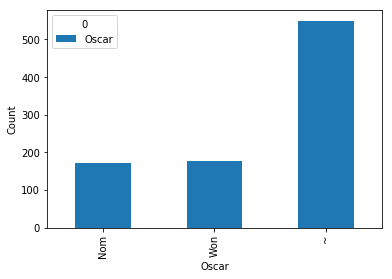

In [30]:
% pylab inline
df.groupby([ 'Oscar'])[['Oscar']].count().plot(kind='bar').set_ylabel('Count')
df.groupby(['Oscar' ])[['Oscar']].count()

#### Figure 1: The 'Nomination' (Nom) and 'Won' are balanced but many actors are not in either of these categories. 

##  Import the actors 'Career' article. 
 * Here we use "wikipediaapi" library to extract the 'Career' section for each actor article that appears in the list.  
 * It is important to note here that the preprocessing is perform as we reading the data. Hopefully, that will save processing time. 

* nltk sentance tokenizer. 
* tag words. 
* root on the original text. stanford nlp library. 
* stop words. 

In [6]:
# Extracting the Career for each actor and adding them to the dataframe
 
all_text=str([])

stop_words = stopwords.words("english")

stop_words = [word.replace("\'", "") for word in stop_words]

wiki_wiki = wikipediaapi.Wikipedia('en')

docs = []

for ind, actor_n in  enumerate(df.Actor ):
    # Uploading the actor article.
    page_py = wiki_wiki.page(actor_n)
    
    # Extracting the "Career" section and preprocessing the text.
    example_sent =  preprocess(lemmatize_doc(str(page_py.section_by_title('Career'))))
    
    # If carrer is not present choose the first available option
    if (example_sent=='none')& (page_py.sections!=[]):
        example_sent = preprocess(lemmatize_doc(str(page_py.section_by_title(page_py.sections[0].title))))
    
    # Creating the bag of words    
    docs.append(example_sent)
    
    # Procesed "Career" section added to the dataframe
    df['career'].iloc[ind] = example_sent


## Topic Extraction
### Latent Dirichlet allocation (LDA) and Non-Negative Matrix Factorization (NMF) is implemented to identifies 5 different topics in the articles. 

In [32]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 2000
n_components = 5
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print("Loading dataset...")
t0 = time()
 
data_samples = docs
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1,3),
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=10,ngram_range=(1,3),
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 0.001s.
Extracting tf-idf features for NMF...
done in 16.898s.
Extracting tf features for LDA...
done in 19.193s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=2000...
done in 0.828s.

Topics in NMF model (Frobenius norm):
Topic #0: stage broadway comedy lead production movie mgm actor act return studio york begin picture direct new york musical actress contract company
Topic #1: school bear father early life mother family attend high school née parent high child university jewish college age brother york new york graduate
Topic #2: award best win award best academy actress academy award nomination nominate performance supporting best supporting receive actor best actress globe golden globe academy award best golden drama
Topic #3: episode series television season guest cbs abc nbc character tv western television series guest starred appearance portray starred cast sitcom drama appear episode
Topic #4: million rel

### We choose Topic 2  for the NMF model (generalized Kullback-Leibler divergence) with tf-idf features
#### Topic #2: award best win award best academy actress academy award nomination nominate performance supporting best supporting receive actor best actress globe golden globe academy award best golden drama

 

## Choose the relevant sentances using cosine_similarities

### Here we identify the 4 most similar sentancess to "Topic 2" in each article ( document) . These sentancess will be uploaded to a new column "simila'. 

In [11]:
def simila(dafr):
    sentence= 'award best award best win academy actress academy award nomination nominate supporting performance best supporting actor receive best actress globe academy award best golden globe golden best actor'

    topic_1 = tf_vectorizer.transform([sentence]) 
    cosine_similarities =linear_kernel(topic_1, tf_vectorizer.transform(sent_tokenize(dafr ))).flatten() 
    list_top = []
 
    for ind in cosine_similarities.argsort()[:-5:-1]:
        list_top.append(sent_tokenize(dafr )[ind])
         
    return list_top
        
df['simila']=df['career'].apply(simila )    

### Labels
#### Using one hot encoding to labels categories

In [12]:
columns = [  'Nom','won','non' ]
labels =    pd.DataFrame(  columns=columns)


labels[[ 'Nom','won','non']] =  pd.DataFrame(pd.get_dummies(df['Oscar']))

In [13]:
labels['Nomwon']= labels['Nom'] + labels['won'] 
labels=labels.drop(['Nom', 'won'], axis=1)
labels.head( )

,non,Nomwon
1,1,0
2,1,0
3,0,1
4,1,0
5,1,0


### Encoding the words
#### Each unique word in the 'bag of words' gets an integer. That will be used to encode the text in the data frame.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
 
cv=CountVectorizer(max_df=0.85, max_features=100000)

word_count_vector=cv.fit_transform(docs)

In [35]:
seq_len = 100
sen_len = 25
features = np.zeros((len(df), seq_len), dtype=int)
career_ints = []
sent_len = []
for i, parag in enumerate(df['simila']  ):
    for ii , sent in enumerate(parag) :
         
        if (sent !='none' and sent !='a' and  sent !='nan' and sent !=''):
              
            caree_var=[cv.vocabulary_[word] for word in sent.split()
                                 if word in cv.vocabulary_.keys() ][0:25]
            sent_len.append(len([cv.vocabulary_[word] for word in sent.split()
                                 if word in cv.vocabulary_.keys() ]))  
            features[i, ii*sen_len :ii*sen_len+len(caree_var)] = caree_var
             
        else:
            caree_var=[cv.vocabulary_[word] for word in sent.split()
                                 if word in cv.vocabulary_.keys() ][0:25]
        career_ints.append(features[i,:])    
            
 

1

In [39]:
review_lens = Counter([ x  for x in sent_len])
print("1 word-length sentance: {}".format(review_lens[1]))
print("Maximum review sentance: {}".format(max(review_lens)))

1 word-length sentance: 2
Maximum review sentance: 155


,0
count,3384.000000
mean,18.344267
std,13.683750
min,0.000000
25%,10.000000
50%,16.000000
75%,24.000000
max,155.000000


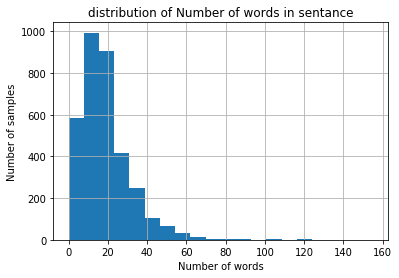

In [40]:
import pylab as pl
#pd.DataFrame.from_dict(  review_lens ) 
review_le = ([ x for x in sent_len])
review_df = pd.DataFrame(review_le)

review_df.hist(bins = 20) 
pl.xlabel('Number of words')
pl.ylabel('Number of samples')
pl.title('distribution of Number of words in sentance')
pd.DataFrame(review_df.describe())

### Prepare the data for the model
### Training, Validation, Test


In [18]:
#Can be replace with train test split

split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels.values[:split_idx ], labels.values[split_idx: ]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape),
      "\nTest set: \t\t{}".format(test_y.shape),
     "\nValidation set: \t{}".format(val_y.shape),
     "\nTrain set: \t\t{}".format(train_y.shape))

 

			Feature Shapes:
Train set: 		(719, 100) 
Validation set: 	(90, 100) 
Test set: 		(90, 100) 
Test set: 		(90, 2) 
Validation set: 	(90, 2) 
Train set: 		(719, 2)


## Build the graph

### Hyperparameters Defining.

* `lstm_size`: Number of units in the hidden layers in the LSTM cells. 
* `lstm_layers`: Number of LSTM layers in the network.
* `batch_size`: The number of articles to feed the network in one training pass.  
* `learning_rate`: Learning rate

In [27]:
import tensorflow as tf 
#tf.reset_default_graph()

For the network itself, we'll be passing in 300 words long vectors. Each batch will be batch_size vectors. We'll also be using dropout on the LSTM layer, so we'll make a placeholder for the keep probability.

### Embedding

Now we'll add an embedding layer. We need to do this because it is inefficient to one-hot encode our classes here. Instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. It is also possible to train an embedding layer using word2vec, then load it here. 


### LSTM cell

 
Next, we'll create our LSTM cells to use in the recurrent network ([TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn)). 

To create a basic LSTM cell for the graph, we'll   use `tf.contrib.rnn.BasicLSTMCell`.

```
tf.contrib.rnn.BasicLSTMCell(num_units, forget_bias=1.0, input_size=None, state_is_tuple=True, activation=<function tanh at 0x109f1ef28>)
```

BasicLSTMCell   takes a parameter `num_units`, the number of units in the cell (`lstm_size`).  

 

Next, we add dropout to the cell with `tf.contrib.rnn.DropoutWrapper`. This just wraps the cell in another cell, but with dropout added to the inputs and/or outputs. It's a really convenient way to make the network better with almost no effort! 


The network will have better performance with more layers. Adding more layers allows the network to learn complex relationships. A simple way to create multiple layers of LSTM cells with `tf.contrib.rnn.MultiRNNCell`:

```
cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
```

Here, `[drop] * lstm_layers` creates a list of cells (`drop`) that is `lstm_layers` long. The `MultiRNNCell` wrapper builds this into multiple layers of RNN cells, one for each cell in the list.

So the final cell we're using in the network is actually multiple  LSTM cells with dropout. But it all works the same from an architectural viewpoint, just a more complicated graph in the cell.

 
 
### RNN forward pass
Now we need to actually run the data through the RNN nodes. We use tf.nn.dynamic_rnn to do this. We pass in the RNN cell you created (our multiple layered LSTM cell for instance), and the inputs to the network.
outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, initial_state=initial_state)
Above I created an initial state, initial_state, to pass to the RNN. This is the cell state that is passed between the hidden layers in successive time steps. tf.nn.dynamic_rnn takes care of most of the work for us. We pass in our cell and the input to the cell, then it does the unrolling and everything else for us. It returns outputs for each time step and the final_state of the hidden layer.


### Output
#### Training Cost
We only care about the final output, we'll be using that as our prediction. So we need to grab the last output with `outputs[:, -1]`, the calculate the cost from that and `labels_`. Since we have more than 2 labels it is important to use the softmax_cross_entropy.

#### Validation accuracy
Here we   calculate the accuracy which I'll use in the validation pass.

#### Batching
This function returning batches from our data. First it removes data such that we only have full batches. Then it iterates through the x and y arrays and returns slices out of those arrays with size [batch_size].

In [28]:
 
lstm_size = 256
#num_units = [128, 64 ]
#lstm_layers = 2
num_units = [128 ]
lstm_layers = 1
batch_size = 30
learning_rate = 0.001
NUM_CLASSES = 2
epochs = 3
keep_prob = 0.5
embed_size = 50  
#seq_len = 80
n_words = len(cv.vocabulary_)+ 1 # Adding 1 because we use 0's for padding, dictionary started at 1

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)
    
with graph.as_default():
    # Basic LSTM cell
 
    lstm = [ tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=n), 
                                           output_keep_prob=keep_prob) for n in num_units]
    cell = tf.contrib.rnn.MultiRNNCell(lstm)
  
 

    initial_state = cell.zero_state(  batch_size , tf.float32)
# RNN forward pass
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
                                             initial_state=initial_state)
    
# Output Training Cost
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], NUM_CLASSES, 
                                                    activation_fn=tf.sigmoid)
    # For multi output
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels_, logits=predictions))
    # For binarry output 
    # cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
# Validation, 
with graph.as_default():
    # For binarry output 
    # correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    # accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    # For multi output  
    correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels_, 1))

    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) 
    
# Batching 
def get_batches(x, y, batch_size=batch_size):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

## Training

Below is the training code. 

In [29]:

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, :],
                    keep_prob: 0.7,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:,:],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
             
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")

Epoch: 0/3 Iteration: 5 Train loss: 0.686
Epoch: 0/3 Iteration: 10 Train loss: 0.510
Epoch: 0/3 Iteration: 15 Train loss: 0.761
Epoch: 0/3 Iteration: 20 Train loss: 0.716
Epoch: 1/3 Iteration: 25 Train loss: 0.610
Val acc: 0.656
Epoch: 1/3 Iteration: 30 Train loss: 0.633
Epoch: 1/3 Iteration: 35 Train loss: 0.687
Epoch: 1/3 Iteration: 40 Train loss: 0.610
Epoch: 1/3 Iteration: 45 Train loss: 0.635
Epoch: 2/3 Iteration: 50 Train loss: 0.547
Val acc: 0.711
Epoch: 2/3 Iteration: 55 Train loss: 0.688
Epoch: 2/3 Iteration: 60 Train loss: 0.678
Epoch: 2/3 Iteration: 65 Train loss: 0.633
